In [1]:
import re, string, time

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.svm import LinearSVC


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import wordcloud

### Reading and understanding the dataset

In [2]:
df = pd.read_csv('D:\\nettech\\datasets\\twitter.csv', encoding="ISO-8859-1", names=['target', 'ids', 'date', 'flag', 'user', 'tweet'])
df.head()

,target,ids,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


We only need 2 columns ie. tweet and the target

In [3]:
df = df[['tweet', 'target']]
df.head()

,tweet,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [4]:
df.shape

(1600000, 2)

Dataset has 1.6m rows

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   tweet   1600000 non-null  object
 1   target  1600000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


There are no null values present in the dataset

In [6]:
df.duplicated().sum()

16309

16.3k Duplicate values are present and must be handled

In [7]:
df.drop_duplicates(keep='first', inplace=True)
df.shape

(1583691, 2)

In [8]:
df['target'] = df['target'].map({0: 0, 4: 1})

### EDA

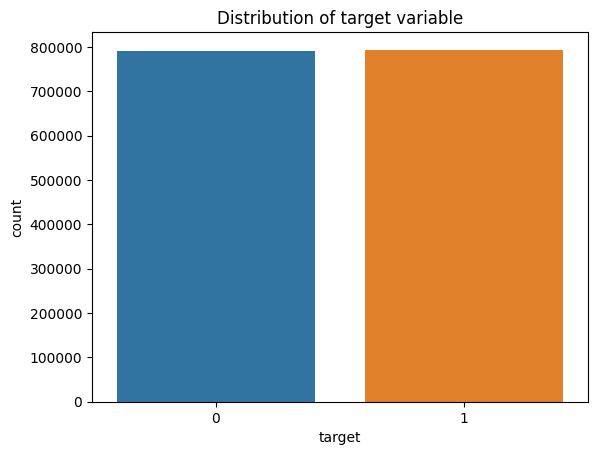

In [9]:
sns.countplot(x = df['target'], data = df)
plt.title('Distribution of target variable')
plt.show()

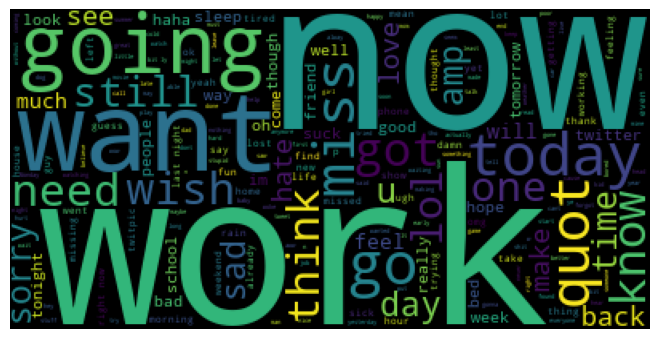

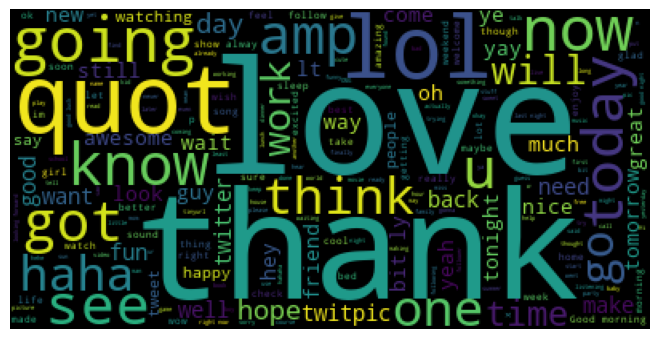

In [10]:
wc = wordcloud.WordCloud(background_color = 'black').generate(' '.join(df[df['target'] == 0]['tweet']))
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

wc2 = wordcloud.WordCloud(background_color = 'black').generate(' '.join(df[df['target'] == 1]['tweet']))
plt.imshow(wc2)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

### Preprocessing

In [11]:
for i in range(20):
    print(df['tweet'][i])

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
my whole body feels itchy and like its on fire 
@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
@Kwesidei not the whole crew 
Need a hug 
@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?
@Tatiana_K nope they didn't have it 
@twittera que me muera ? 
spring break in plain city... it's snowing 
I just re-pierced my ears 
@caregiving I couldn't bear to watch it.  And I thought the UA loss was embarrassing . . . . .
@octolinz16 It it counts, idk why I did either. you never talk to me anymore 
@smarrison i would've been the first, but i didn't have a gun.    not rea

Referred from [here](https://www.kaggle.com/code/stoicstatic/twitter-sentiment-analysis-for-beginners?scriptVersionId=68181216&cellId=5)

By observing few tweets we can see that there are some tags, hashtags , URL's, slang words, emojis, consecutive words <br>
Hence we need to perform the following steps:<br>
1. Convert the tweet to lower case <br>
2. Replace URL's <br>
3. Replace tags and hashtags <br>
4. Remove punctuations <br>
5. Remove emojis
6. Remove stop words <br>
7. Remove short words <br>
8. Replace consecutive alphabets <br>
9. Lemmatization 

In [12]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    
    # Step 2 : Replace URL's with 'URL'
    url_pattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    text = re.sub(url_pattern, ' URL', text)
    
    # Step 3 : Replace @Usernames with 'USER'
    user_pattern = '@[^\s]+'
    text = re.sub(user_pattern, ' USER', text)
    
    # Step 4 : Remove Punctuations
    text = re.sub(r'[^\w\s]', '', text)
    
    # Step 5 : Remove Stopwords
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in stop_words]
    text = ' '.join(tokens_without_sw)
    
    # Step 6 : Replace Emojis
    for a in emojis.keys():
        text = text.replace(a, ' EMOJI')
        
    # Step 7 : Replace Numbers
    text = re.sub('[0-9]+', 'NUM', text)
    
    # Step 8 : Replace Sequences
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    text = re.sub(sequencePattern, seqReplacePattern, text)
    
    # Step 9 : Lemmatize
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    
    # Step 1 : Lower Case
    text = text.lower()
    
    return text

In [13]:
t = time.time()
df['tweet'] = df['tweet'].apply(preprocess_text)
print(f'Preprocessing complete \n Time taken = {time.time() - t}')

Preprocessing complete 
 Time taken = 299.0573558807373


In [14]:
df

,tweet,target
0,user url aww thats bummer you shoulda got davi...,0
1,upset cant update facebook texting might cry r...,0
2,user i dived many time ball managed save num t...,0
3,whole body feel itchy like fire,0
4,user behaving im mad i cant see,0
...,...,...
1599995,just woke having school best feeling ever,1
1599996,thewdbcom very cool hear old walt interview â url,1
1599997,are ready mojo makeover ask detail,1
1599998,happy numth birthday boo all time tupac amaru ...,1


### Modelling

In [15]:
X = df['tweet']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [16]:
lr = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
nb = MultinomialNB()
bnb = BernoulliNB(alpha=2)
cnb = ComplementNB()
svc = LinearSVC()

models = [nb, svc, bnb, cnb]

for model in models:
    model.fit(X_train, y_train)
    t = time.time()
    y_preds = model.predict(X_test)
    print(f'Accuracy score for {model.__class__.__name__} : {accuracy_score(y_test, y_preds)}')
    print(f'Classification report for {model.__class__.__name__} : \n {classification_report(y_test, y_preds)}')
    print(f'time taken : {time.time()-t} seconds.')
    print('*' * 80)
    

Accuracy score for MultinomialNB : 0.7661110058723243
Classification report for MultinomialNB : 
               precision    recall  f1-score   support

           0       0.76      0.78      0.77     78888
           1       0.77      0.75      0.76     79482

    accuracy                           0.77    158370
   macro avg       0.77      0.77      0.77    158370
weighted avg       0.77      0.77      0.77    158370

time taken : 0.4045267105102539 seconds.
********************************************************************************
Accuracy score for LinearSVC : 0.7790364336679927
Classification report for LinearSVC : 
               precision    recall  f1-score   support

           0       0.79      0.76      0.78     78888
           1       0.77      0.79      0.78     79482

    accuracy                           0.78    158370
   macro avg       0.78      0.78      0.78    158370
weighted avg       0.78      0.78      0.78    158370

time taken : 0.3472278118133545 seco